In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import svd

plt.ion()
%matplotlib widget

### Notation
Let $\mathbf{M}=(m_{ij})_{\substack{1\leq i\leq n\\1\leq j\leq m}}$ be an $n\times m$ matrix. We use the following notations:
- $\mathbf{M}_{ij}$ to denote the entry at the $i$-th row and $j$-th column, $m_{ij}$
- $\mathbf{M}_{i\bullet}$ to denote the row-vector describing the $i$-th row, $(m_{ij})_{1\leq j\leq m}$
- $\mathbf{M}_{\bullet j}$ to denote the column-vector describing the $j$-th column, $(m_{ij})_{1\leq i\leq n}^\top$

## Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that transforms data into a new coordinate system.
It finds the directions (principal components) that capture the maximum variance in the data.

Consider the datamatrix $\mathbf{M}\in\mathbb{C}^{n\times m}$ of $n$ $m$-dimensional samples. With PCA, we want to identify the primary directions (i.e., the directions which explain the largest variance of the data) from the origin.

Algorithm:
1. Center the columns of $\mathbf{M}$ around the origin by subtracting $\mathbb{E}[\mathbf{M}_{\bullet i} \mid 1\leq i \leq m]$ from each column.
2. Compute the [covariance matrix](https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices) $\mathbf{C} := \operatorname{cov}(\mathbf{M}, \mathbf{M}) := \frac{\mathbf{M}^\top\mathbf{M}}{n-1}$.
3. Calculate the eigendecomposition for $\textbf{C}$: $\textbf{C} = \textbf{Q}\mathbf{\Lambda} \textbf{Q}^{-1}$, where the columns $\textbf{Q}_{\bullet j}$ are the eigenvectors of $\textbf{C}$ and $\mathbf{\Lambda} := \operatorname{diag}(\lambda_1, \dots, \lambda_m)$ are the respective $m$ eigenvalues.
4. Project data onto the top-$k$ eigenvectors.


## Covariance Matrix

In [2]:
# Randomly sample correlated data
np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[3, 2], [2, 2]], size=100)

# To show that the described calculation for the covariance matrix above is correct ;)
X_centered = X - np.mean(X, axis=0)
cov_matrix = (X_centered.T @ X_centered) / (X.shape[0] - 1)

assert np.allclose(cov_matrix, np.cov(X, rowvar=False)), "Something is wrong in the calculation of the covariance matrix :("

## Singular Value Decomposition (SVD)

SVD factorizes any real matrix $M\in\mathbb{C}^{n\times m}$ into three matrices:
$$\mathbf{M} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top$$

- $\mathbf{U}$ and $\mathbf{V}$ are unitary matrices (i.e., $\mathbf{U}\mathbf{U}^* = \mathbf{I}$ and columns of $U$ form an orthonormal basis for $\mathbb{C}^n$).
- $\mathbf{\Sigma} = \operatorname{diag}(s_1, \dots, s_m)$ is a diagonal matrix of the "singular values" $s_i$. $\mathbf{\Sigma}$ is usually sorted such that $s_i \geq s_{i+1}$ for all $1\leq i < m$. If $n\neq m$, then $\mathbf{\Sigma}$ is a $n\times m$ block matrix where the upper block is $\operatorname{diag}(s_1, \dots, s_m)$ and the lower consists of only 0.

### Note
The number of non-zero entries in $\mathbf{\Sigma}$ is precisely the rank of $\mathbf{M}$ such that we can think of $\mathbf{\Sigma}$ as a $r\times r$ matrix with $r := \operatorname{rank}(\mathbf{M})$.


# Computing PCA using SVD

While PCA is traditionally defined through the eigendecomposition of the covariance matrix, we can actually compute it using Singular Value Decomposition.

Let $\mathbf{M}$, $\mathbf{C}$, $\mathbf{U}$, $\mathbf{\Sigma}$, and $\mathbf{V}$ be matrices as characterized above. We can easily compute an eigendecomposition of $C$ using the SVD $\mathbf{M} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top$ as follows
$$\begin{align*}
\mathbf{C} &= \frac{\mathbf{M}^\top\mathbf{M}}{n-1}\\
&= \frac{(\mathbf{U}\mathbf{\Sigma} \mathbf{V}^\top)^\top (\mathbf{U}\mathbf{\Sigma} \mathbf{V}^\top)}{n-1} \tag{$(\mathbf{A}\mathbf{B})^\top = \mathbf{B}^\top \mathbf{A}^\top$}\\
&= \frac{\mathbf{V}\mathbf{\Sigma} \mathbf{U}^\top \mathbf{U}\mathbf{\Sigma} \mathbf{V}^\top}{n-1} \tag{$\mathbf{U}\mathbf{U}^\top = \mathbf{I}$}\\
&= \frac{\mathbf{V}\mathbf{\Sigma}^2\mathbf{V}^\top}{n-1} \tag{$\mathbf{V}\mathbf{V}^\top = \mathbf{I}$}\\
&= \mathbf{V}\frac{\mathbf{\Sigma}^2}{n-1}\mathbf{V}^{-1}.
\end{align*}$$
This shows that $\mathbf{V}_{\bullet i}$ are eigenvectors of $\mathbf{C}$ with corresponding eigenvalues $\lambda_i = \frac{s_i^2}{𝑛−1}$, where $s_i$ are the singular values of $\mathbf{M}$.

Now let us see this in action. The following snippet samples $n=100$ correlated 2d datapoints $\mathbf{X}$ and calculates the PCA and SVD. We then plot the mean-centered datapoints and draw in 1) the principal components (scaled by their explained standard deviation) and 2) the column vectors $\mathbf{V}_{\bullet i}$ scaled by $\frac{s_i^2}{n-1}$. We can also visualize these spaces by 3) projecting the mean-centered datapoints into $\operatorname{span}(\mathbf{Q}_{\bullet i})$ and $\operatorname{span}(\mathbf{V}_{\bullet i})$ respectively.

### Questions:
- Why doesn't it matter that the second primary component points at a different direction? Why don't the PCA encoded and SVD encoded data overlap (what transformation differentiates them?)

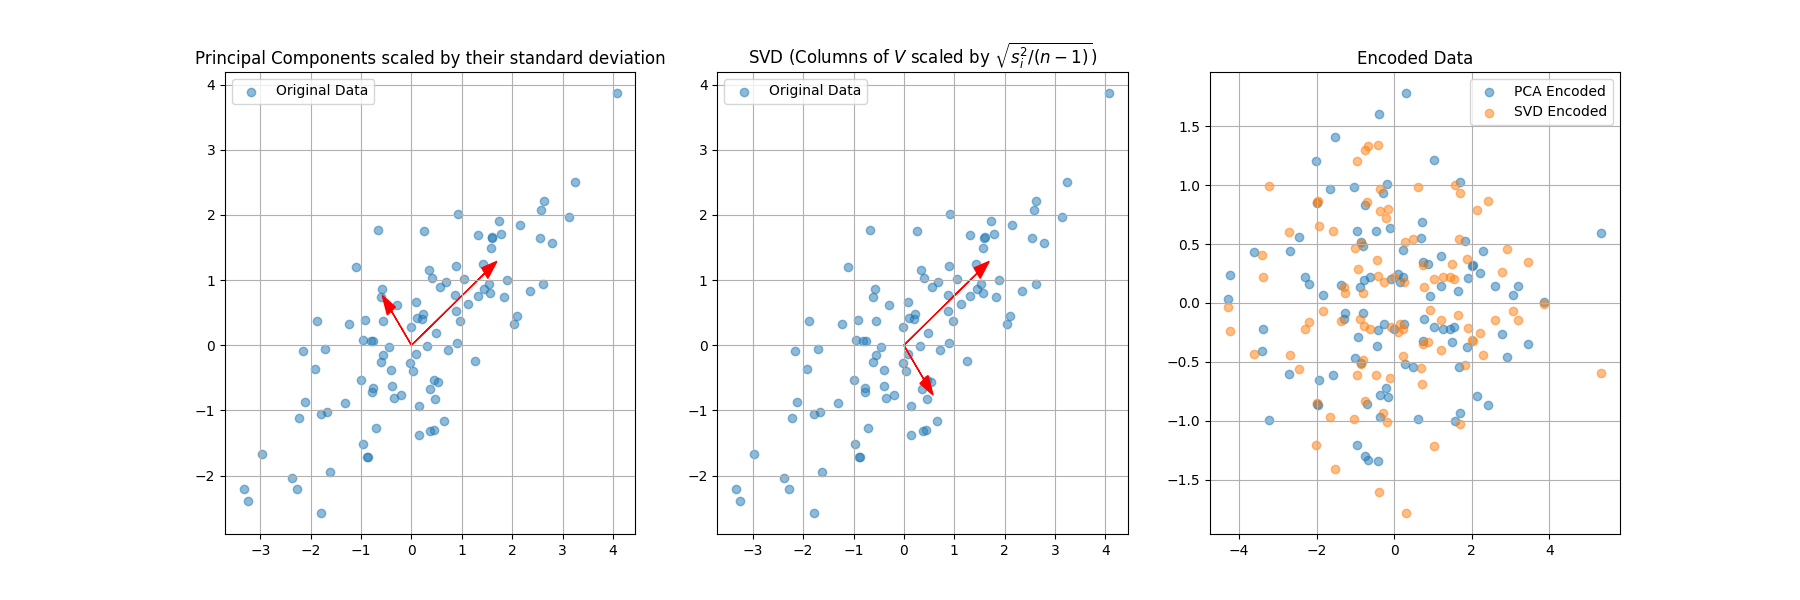

In [9]:
# Create 100 correlated 2d datapoints
np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[3, 2], [2, 2]], size=100)

# Perform a PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Compute the SVD
X_centered = X - X.mean(axis=0)
U, S, VT = svd(X_centered)
X_svd = U[:,:S.shape[0]] @ np.diag(S)
assert np.allclose(X_svd @ VT, X_centered), "Something went wrong with the SVD"
assert np.allclose(X_svd, X_centered @ VT.T), "X encoded via SVD differs from X_svd"

# Plotting it all
# Plotting PCA
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
for i in range(2):
    vector = pca.components_[i] * np.sqrt(pca.explained_variance_[i])
    ax[0].arrow(0, 0, vector[0], vector[1], head_width=0.2, color='r')
ax[0].set_title("Principal Components scaled by their standard deviation")
#ax[0].set_axis('equal')
ax[0].grid(True)
ax[0].legend()

# Plotting SVD
ax[1].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
for i in range(2):
    vector = np.sqrt((S[i]**2)/(100-1)) * VT.T[i]
    ax[1].arrow(0, 0, vector[0], vector[1], head_width=0.2, color='r')
ax[1].set_title("SVD (Columns of $V$ scaled by $\\sqrt{s_i^2 / (n-1)}$)")
#ax[1].axis('equal')
ax[1].grid(True)
ax[1].legend()

ax[2].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, label='PCA Encoded')
ax[2].scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.5, label='SVD Encoded')
ax[2].set_title("Encoded Data")
#ax[2].axis('equal')
ax[2].grid(True)
ax[2].legend()
#fig.show()
None; # < to avoid printing something

# Encoding Random Datapoints

Now lets keep the $\mathbf{V}$ matrix from the example above and encode a newly sampled set of 1000 samples into the eigenspaces.

### Questions
- What do you observe about the distribution of the encoded datapoints?
- What would happen if we encoded datapoints sampled from a different multivariate distribution?

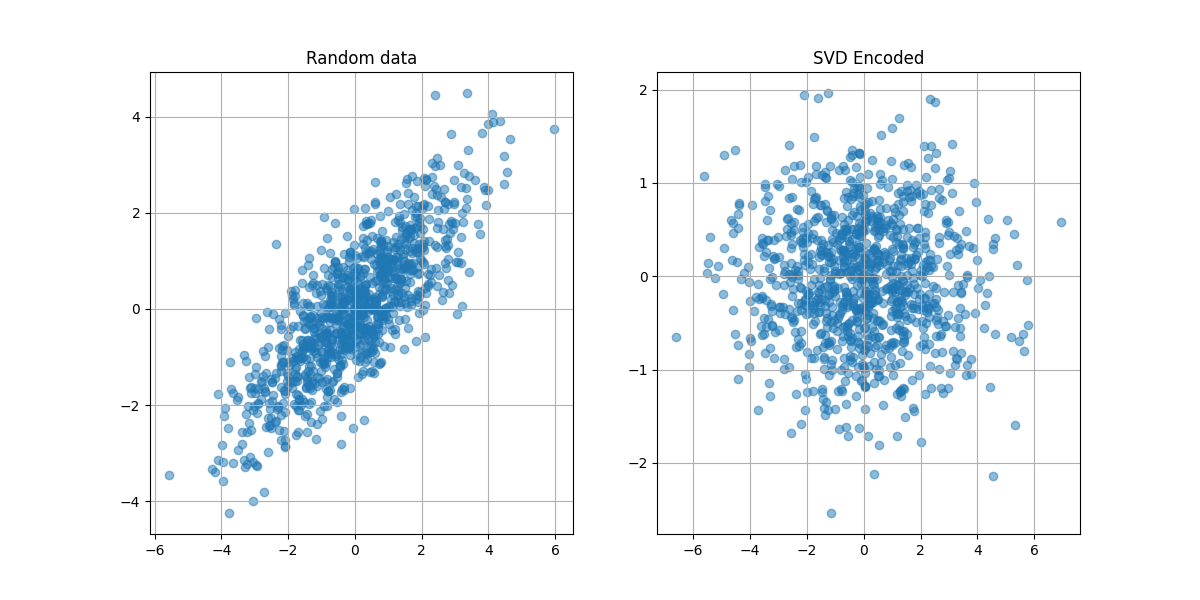

In [10]:
np.random.seed(42)
Z = np.random.multivariate_normal([0, 0], [[3, 2], [2, 2]], size=1000)
Z_centered = Z - np.mean(Z, axis=0)
Z_encoded = Z @ VT.T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].scatter(Z_centered[:, 0], Z_centered[:, 1], alpha=0.5, label='Random data')
ax[0].set_title("Random data")
#ax[0].axis('equal')
ax[0].grid(True)
#ax[0].legend()

ax[1].scatter(Z_encoded[:, 0], Z_encoded[:, 1], alpha=0.5, label='Random data encoded')
ax[1].set_title("SVD Encoded")
#ax[1].axis('equal')
ax[1].grid(True)
#ax[1].legend()
#fig.show()
None; # < to avoid printing something

# Dimensionality Reduction

Finally, since the singular values $s_\bullet$ are typically sorted such that $s_i >= s_{i+1}$, we can reduce the data to only its top $k$ principal components simply by multiplication with only the submatrix $\mathbf{V}' = (v_{ij})_{\substack{1\leq i\leq m\\1\leq j\leq k}} \in \mathbb{C}^{m\times k}$.

This approach is often called *truncated SVD* and there exist more (time- and memory-) efficient randomized approximations to SVD ([Halko et al., 2011](https://doi.org/10.1137/090771806)) rather than performing an exact SVD.

### Further Reading
- Carl Eckart and Gale Young. 1936. [The approximation of one matrix by another of lower rank](https://doi.org/10.1007/BF02288367). In *Psychometrika 1*, pages 211&ndash;218.
- Nathan Halko, Per-Gunnar Martinsson, and Joel A. Tropp. 2011. [Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions](https://doi.org/10.1137/090771806). In *SIAM Rev. 53*, Volume 2, pages 217&ndash;288.

Mean Square Error of Encoding with the 1 principal components:   5.62%
Mean Square Error of Encoding with the 2 principal components:   0.14%
Mean Square Error of Encoding with the 3 principal components:   0.00%


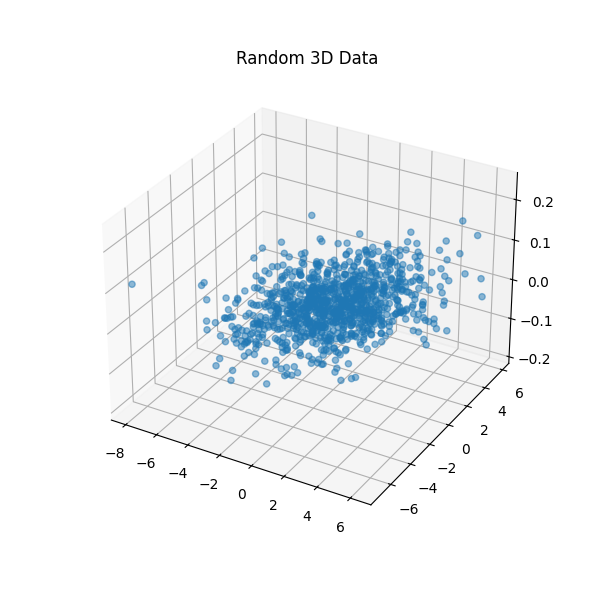

In [11]:
# Randomly sample correlated data
np.random.seed(42)
M = np.array([[3,3,0], [0,-1,0], [0,.1,.1]])
M = np.concatenate((M, -M), axis=0)
cov = np.cov(M.T);
X = np.random.multivariate_normal([0, 0, 0], cov, size=1000)
X_centered = X - np.mean(X, axis=0)

# SVD
_, _, VT = svd(X_centered)

Z = np.random.multivariate_normal([0, 0, 0], cov, size=100)
Z_centered = Z - np.mean(Z, axis=0)
for k in range(1,4):
  Z_enc = Z_centered @ VT.T[:,:k]  # Project onto the two primary components
  Z_dec = Z_enc @ VT[:k, :]
  mse = ((Z_centered.flatten() - Z_dec.flatten())**2).mean()
  print(f"Mean Square Error of Encoding with the {k} principal components: {mse*100:6.2f}%")

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_centered[:, 0], X_centered[:, 1], X_centered[:, 2], alpha=0.5, label='Random data')
#for k in range(1,4):
#  Z_reproj = Z_centered @ VT.T[:,:k] @ VT[:k, :]
#  ax.scatter(Z_reproj[:, 0], Z_reproj[:, 1], Z_reproj[:, 2], alpha=0.5, label=f'Top {k} components')
ax.set_title("Random 3D Data")
#ax.axis('equal')
ax.grid(True)
# ax.legend()
# fig.show()
None; # < to avoid printing something

# PCA vs. SVD

Arguably, the title is misleading. As we described above, PCA is typically defined using the eigendecomposition of the covariance matrix. However, at its core, PCA is only about finding the *principal components* of data and, in that sense, SVD is an alternative way to the eigendecomposition of the covariance matrix to compute the PCA. As such, the title should rather read: *Eigendecomposition of the Covariance Matrix vs. SVD*.

<!--Let $n$ be the number of datapoints and $m$ the dimension of a single datapoint. Consider the datamatrix $\mathbf{M}\in \mathbb{K}^{n\times m}$ where $\mathbb{K} \in \{\mathbb{R}, \mathbb{C}\}$.

SVD has time complexity $O(nm^2)$, whereas the eigendecomposition of $M^\top M \in\mathbb{K}^{m\times m}$ has time complexity $O(m^3)$. -- This does not seem right; Maybe find out the time and memory complexity of randomized approaches?-->

`TODO why is SVD better than PCA?`

# Latent Semantic Analysis

Latent Semantic Analysis (LSA), also known as *Latent Semantic Indexing* (LSI), is a natural language processing technique used to remove hidden relationships between words within documents. It works by applying Singular Value Decomposition (SVD) to a term-document matrix to reduce its dimensionality to the principal components and better capture the underlying semantic structure of the text.

The following snippets load the NLTK `movie_reviews` corpus and apply simple Bag of Words (BoW), TF-IDF

### Questions

- How does SVD get affected by stopwords?
- Could throwing away dimensions using SVD result in better effectiveness than using the full features?

In [ ]:
import pandas as pd
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import movie_reviews
nltk.download('stopwords')
nltk.download('movie_reviews')

import os

# Load data
docs = [movie_reviews.raw(fileid) for fileid in movie_reviews.fileids()]
labels = [1 if fileid.startswith('pos') else 0 for fileid in movie_reviews.fileids()]  # 1=pos, 0=neg

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [13]:
################################################################################
# BoW document representations                                                 #
################################################################################
bow_vectorizer = CountVectorizer(stop_words='english')#, max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Train & Eval
clf_bow = LogisticRegression(max_iter=500)
clf_bow.fit(X_train_bow, y_train)
pred_bow = clf_bow.predict(X_test_bow)
print(f"BoW       Accuracy ({X_test_bow.shape[1]:5}-dimensional): {accuracy_score(y_test, pred_bow)*100:5.1f}%")

################################################################################
# TF-IDF document representations                                              #
################################################################################
tfidf_vectorizer = TfidfVectorizer(stop_words='english')#, max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train & Eval
clf_tfidf = LogisticRegression(max_iter=500)
clf_tfidf.fit(X_train_tfidf, y_train)
pred_tfidf = clf_tfidf.predict(X_test_tfidf)
print(f"TF-IDF    Accuracy ({X_test_bow.shape[1]:5}-dimensional): {accuracy_score(y_test, pred_tfidf)*100:5.1f}%")

################################################################################
# SVD on TF-IDF document representations                                       #
################################################################################
# Can only go up to 1600 with the SVD since that is the number of our samples
for k in (1, 100, 200, 250, 500, 750, 1000, 1600):
  # Uses a randomized approximation of SVD: https://arxiv.org/pdf/0909.4061
  svd_model = TruncatedSVD(n_components=k, random_state=42)
  X_train_svd = svd_model.fit_transform(X_train_tfidf)
  X_test_svd = svd_model.transform(X_test_tfidf)

  # Train & Eval
  clf_svd = LogisticRegression(max_iter=500)
  clf_svd.fit(X_train_svd, y_train)
  pred_svd = clf_svd.predict(X_test_svd)
  print(f"LSA       Accuracy ({X_test_svd.shape[1]:5}-dimensional): {accuracy_score(y_test, pred_svd)*100:5.1f}%")

################################################################################
# SVD (Exact) on TF-IDF document representations                               #
################################################################################
term_doc = X_train_tfidf.toarray()  # document-term matrix (docs x terms)
U, S, VT = svd(term_doc, full_matrices=False)
for k in (1, 100, 200, 250, 500, 750, 1000, 1600):
  X_train_svd = X_train_tfidf @ VT.T[:,:k]
  X_test_svd = X_test_tfidf @ VT.T[:,:k]

  # Train & Eval
  clf_svd = LogisticRegression(max_iter=500)
  clf_svd.fit(X_train_svd, y_train)
  pred_svd = clf_svd.predict(X_test_svd)
  print(f"Exact LSA Accuracy ({X_test_svd.shape[1]:5}-dimensional): {accuracy_score(y_test, pred_svd)*100:5.1f}%")

BoW       Accuracy (35943-dimensional):  82.8%
TF-IDF    Accuracy (35943-dimensional):  82.0%
LSA       Accuracy (    1-dimensional):  51.2%
LSA       Accuracy (  100-dimensional):  76.5%
LSA       Accuracy (  200-dimensional):  79.0%
LSA       Accuracy (  250-dimensional):  80.0%
LSA       Accuracy (  500-dimensional):  80.2%
LSA       Accuracy (  750-dimensional):  81.2%
LSA       Accuracy ( 1000-dimensional):  81.5%
LSA       Accuracy ( 1600-dimensional):  82.0%
Exact LSA Accuracy (    1-dimensional):  51.2%
Exact LSA Accuracy (  100-dimensional):  76.2%
Exact LSA Accuracy (  200-dimensional):  79.0%
Exact LSA Accuracy (  250-dimensional):  79.8%
Exact LSA Accuracy (  500-dimensional):  79.8%
Exact LSA Accuracy (  750-dimensional):  81.8%
Exact LSA Accuracy ( 1000-dimensional):  81.2%
Exact LSA Accuracy ( 1600-dimensional):  82.0%
